<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-05-tree-based-models-bagging-quantile-regression-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.5 Quantile Regression Forest (QRF)

Quantile Regression Forests (QRF) is a machine learning method that extends Random Forests to predict conditional quantiles of a response variable, rather than just the mean. It’s particularly useful for modeling the uncertainty and heterogeneity in data by estimating the full conditional distribution of the response variable, allowing you to predict specific quantiles (e.g., median, 90th percentile) instead of a single point estimate. This makes QRF valuable in applications like forecasting, risk analysis, and decision-making under uncertainty.

## Overview

Quantile Regression Forests, introduced by Meinshausen (2006), combine the principles of Random Forests (ensemble of decision trees) with quantile regression. While a standard Random Forest predicts the conditional mean of the response variable given predictors, QRF estimates the conditional quantiles (e.g., 10th, 50th, or 90th percentiles). This is achieved by maintaining the full set of observed response values in the leaf nodes of the trees and using them to approximate the conditional distribution.

QRF is particularly effective for:

- Modeling non-linear relationships.
- Capturing heteroscedasticity (varying variance in the response variable).
- Providing prediction intervals and uncertainty quantification.




### Key Features of Quantile Regression Forests

1. **Non-parametric Approach**: QRF does not assume a specific distribution for the response variable, making it robust to non-Gaussian data and outliers.
2. **Quantile Estimation**: It can estimate any quantile (e.g., τ = 0.1 for the 10th percentile, τ = 0.5 for the median) of the conditional distribution.
3. **Uncertainty Quantification**: QRF provides prediction intervals (e.g., 10th to 90th percentile) to quantify uncertainty.
4. **Handles High-Dimensional Data**: Like Random Forests, QRF can handle many predictors and complex interactions between them.
5. **Robustness**: Inherits the robustness of Random Forests to noise and irrelevant features.
6. **Flexibility**: Works well for both regression and classification problems, though it’s primarily used for regression.



### How Quantile Regression Forests Work

QRF builds on the Random Forest algorithm but modifies how predictions are made. Instead of averaging the response values in a leaf node to predict the mean, QRF retains all response values in the leaf nodes and uses them to estimate the conditional cumulative distribution function (CDF) for a given input. Quantiles are then derived from this estimated CDF.

Here’s a step-by-step explanation of how QRF works, including the relevant equations:

1. Data Preparation

- A dataset with predictors $X = \{x_1, x_2, \dots, x_n\}$ (where each $x_i$ in $\mathbb{R}^p$) and response variable $Y = \{y_1, y_2, \dots, y_n\}$.
- For a new input $x$, estimate the conditional quantiles $Q_Y(\tau | x)$, where $\tau \in (0, 1)$ is the desired quantile (e.g., $\tau = 0.5$ for the median).

The conditional quantile $Q_Y(\tau | x)$ is defined as:

$$ Q_Y(\tau | x) = \inf \{ y : P(Y \leq y | X = x) \geq \tau \} $$

This represents the value $y$ such that the probability of $Y \leq y$ given $X = x$ is at least $\tau$.

2. Build a Random Forest

QRF constructs an ensemble of decision trees using the Random Forest algorithm:

- `Bootstrap Sampling`: For each tree $t = 1, 2, \dots, T$, sample a random subset of the data (with replacement) to create a bootstrap sample.

- `Feature Subsampling`: At each node of a tree, randomly select a subset of features (e.g., $m < p$) to consider for splitting.

- `Splitting Criterion`: Use a criterion (e.g., variance reduction) to split nodes, as in standard Random Forests. The split at node $h$ minimizes:

$$ \text{Impurity} = \sum_{i \in \text{left child}} (y_i - \bar{y}_{\text{left}})^2 + \sum_{i \in \text{right child}} (y_i - \bar{y}_{\text{right}})^2 $$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the means of the response values in the left and right child nodes, respectively.

- Each tree grows until a stopping criterion is met (e.g., minimum node size or maximum depth).

- Unlike standard Random Forests, QRF stores all response values $y_i$ for the training samples that fall into each leaf node, not just their mean.

3. Assign Weights to Observations

For a new input $x$, QRF computes the weight of each training observation $y_i$ based on its proximity to $x$ in the forest:

- For each tree $t$, identify the leaf node  $L_t(x)$ that $x$ falls into.

- Assign a weight $w_i(x)$ to each training observation $y_i$ based on whether it falls into the same leaf as \( x \) across all trees:

$$ w_i(x) = \frac{1}{T} \sum_{t=1}^T \mathbb{I}\{ (x_i, y_i) \in L_t(x) \} $$

where $\mathbb{I}\{ \cdot \}$ is the indicator function (1 if the condition is true, 0 otherwise), and $L_t(x)$ is the leaf node in tree $t$ containing $x$. The weight $w_i(x)$ represents the average proportion of trees where $x_i$ and $x$ share the same leaf.

4. Estimate the Conditional CDF

Using the weights $w_i(x)$, QRF approximates the conditional cumulative distribution function (CDF) of $Y$ given $X = x$:

$$ \hat{F}(y | x) = \sum_{i=1}^n w_i(x) \mathbb{I}\{ y_i \leq y \} $$

This is a weighted empirical CDF, where each observation $y_i$ contributes to the CDF based on its weight $w_i0(x)$.

5. Compute Conditional Quantiles

To estimate the conditional quantile $Q_Y(\tau | x)$ for a given $\tau$, find the value $y$ such that the estimated CDF reaches or exceeds $\tau$:

$$ \hat{Q}_Y(\tau | x) = \inf \{ y : \hat{F}(y | x) \geq \tau \} $$

In practice, this is computed by sorting the response values $y_i$ with non-zero weights $w_i(x)$ and finding the value $y$ where the cumulative sum of weights reaches $\tau$.

For example:

- Sort the $y_i$ values in ascending order: $y_{(1)} \leq y_{(2)} \leq \dots \leq y_{(n)}$.

- Compute the cumulative weights: $\sum_{i: y_i \leq y_{(k)}} w_i(x)$.

- Find the smallest $y_{(k)}$ such that $\sum_{i: y_i \leq y_{(k)}} w_i(x) \geq \tau$.

6. Prediction Intervals (Optional)

To construct a prediction interval (e.g., 80% interval), compute the quantiles for $\tau = 0.1$ and $\tau = 0.9$:

$$ \hat{Q}_Y(0.1 | x), \hat{Q}_Y(0.9 | x) $$

This interval captures the central 80% of the conditional distribution of $Y$.

7. Output

For a given input $x$, QRF outputs:

- The estimated quantiles $\hat{Q}_Y(\tau | x)$ for specified $\tau$ (e.g., median for $\tau = 0.5$).

- Optionally, prediction intervals or the full conditional distribution.



Below is a flowchart summarizing the QRF algorithm:


![alt text](http://drive.google.com/uc?export=view&id=1l61dWCA6kQkFf7Q2-hNZEu78cc8Z-flu)


### QRF Differs from Standard Random Forests

- **Standard Random Forest**: Predicts the conditional mean \( \mathbb{E}[Y | X = x] \) by averaging the response values in the leaf nodes.
- **QRF**: Retains all response values in the leaf nodes and uses them to estimate the conditional CDF, allowing quantile predictions.


### Advantages and Limitations

**Advantages**:

- Provides a full picture of the conditional distribution, not just the mean.
- Handles complex, non-linear relationships without distributional assumptions.
- Robust to outliers and heteroscedasticity.
- Can generate prediction intervals for uncertainty quantification.

**Limitations**:

- Computationally intensive, especially for large datasets, as it stores all response values in leaf nodes.
- Interpretability is limited compared to simpler models like linear quantile regression.
- Performance depends on the quality and diversity of the Random Forest ensemble.






### Applications

- **Finance**: Estimating quantiles of asset returns for risk management (e.g., Value-at-Risk).
- **Environmental Science**: Predicting extreme weather events (e.g., 95th percentile of rainfall).
- **Healthcare**: Modeling variability in patient outcomes.
- **Energy**: Forecasting energy demand with uncertainty intervals.




In [1]:
!pip install quantile-forest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


MAE for median predictions: 2.31
Quantile Loss (0.1): 0.53
Quantile Loss (0.9): 0.56

Feature Importance:
    Feature  Importance
3      CHAS    0.000699
1        ZN    0.000913
8       RAD    0.004671
2     INDUS    0.007105
6       AGE    0.012833
11        B    0.013327
9       TAX    0.015175
10  PTRATIO    0.015819
4       NOX    0.016540
0      CRIM    0.039718
7       DIS    0.051867
12    LSTAT    0.376561
5        RM    0.444772


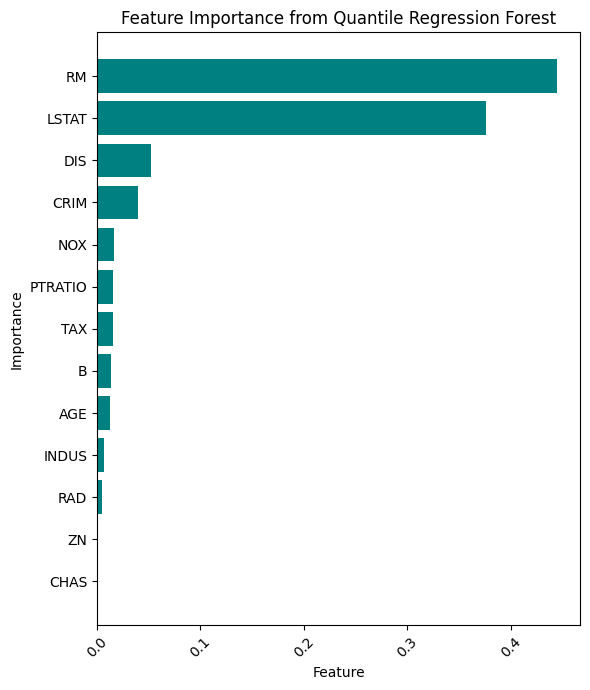

In [2]:
# Import required libraries
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and prepare Boston Housing data (from your code)
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Create a data frame with selected variables
selected_cols = ['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = df[selected_cols]

# Convert CHAS to categorical variable
df['CHAS'] = df['CHAS'].astype('category')

# Convert RAD and TAX to numeric
df['RAD'] = pd.to_numeric(df['RAD'])
df['TAX'] = pd.to_numeric(df['TAX'])

# Separate features (X) and target (y)
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# Split data into training (70%) and test (30%) sets, stratified by CHAS
seeds = 11076
tr_prop = 0.70
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1-tr_prop, random_state=seeds, stratify=X['CHAS'])

# Identify numeric columns
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
train_X[numeric_cols] = scaler.fit_transform(train_X[numeric_cols])
test_X[numeric_cols] = scaler.transform(test_X[numeric_cols])

# Initialize Quantile Regression Forest
quantiles = [0.1, 0.5, 0.9]  # Quantiles to predict (lower, median, upper)
qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=seeds)

# Fit the model
qrf.fit(train_X, train_y)

# Predict quantiles on test set
y_pred_quantiles = qrf.predict(test_X, quantiles=quantiles)

# Extract predictions for each quantile
y_pred_lower = y_pred_quantiles[:, 0]  # 0.1 quantile
y_pred_median = y_pred_quantiles[:, 1]  # 0.5 quantile (median)
y_pred_upper = y_pred_quantiles[:, 2]  # 0.9 quantile

# Evaluate model performance
# Mean Absolute Error for median predictions
mae_median = mean_absolute_error(test_y, y_pred_median)
print(f"MAE for median predictions: {mae_median:.2f}")

# Quantile Loss for 0.1 and 0.9 quantiles
def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.mean(np.where(errors >= 0, quantile * errors, (quantile - 1) * errors))

qloss_lower = quantile_loss(test_y, y_pred_lower, 0.1)
qloss_upper = quantile_loss(test_y, y_pred_upper, 0.9)
print(f"Quantile Loss (0.1): {qloss_lower:.2f}")
print(f"Quantile Loss (0.9): {qloss_upper:.2f}")

# Variable Importance
feature_importance = qrf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True) # Changed to ascending=True

print("\nFeature Importance:")
print(importance_df)

# Visualize Feature Importance
plt.figure(figsize=(6, 7))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Quantile Regression Forest')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Quantile Regression Forest from scratch in Python

In [3]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data



In [5]:
# Load and prepare Boston Housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Create a data frame with selected variables
selected_cols = ['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'] # Using uppercase based on common usage for this dataset

df = df[selected_cols]

# Convert chas to categorical variable
df['CHAS'] = df['CHAS'].astype('category')

# Convert rad and tax to numeric
df['RAD'] = pd.to_numeric(df['RAD'])
df['TAX'] = pd.to_numeric(df['TAX'])

# Separate features (X) and target (y)
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# Split data into training (70%) and test (30%) sets, stratified by chas
seeds = 11076
tr_prop = 0.70
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1-tr_prop, random_state=seeds, stratify=X['CHAS'])

# Identify numeric columns
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
train_X[numeric_cols] = scaler.fit_transform(train_X[numeric_cols])
test_X[numeric_cols] = scaler.transform(test_X[numeric_cols])

# Display the head of the transformed dataframes to verify
display(train_X.head())
display(test_X.head())
display(train_y.head())
display(test_y.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
107,-0.388864,-0.493412,-0.335169,0,-0.267170,-0.285052,0.602566,-0.820935,-0.503367,-0.120132,1.132491,0.327956,0.218944
392,0.932718,-0.493412,1.057655,0,1.350657,-1.820965,1.020235,-0.988288,1.702267,1.567293,0.808024,0.430418,1.840385
467,0.106566,-0.493412,1.057655,0,0.308058,-0.459620,0.931746,-0.622478,1.702267,1.567293,0.808024,-0.299497,1.230421
117,-0.386576,-0.493412,-0.123472,0,-0.024496,-0.434279,0.510537,-0.524128,-0.387281,0.167089,-0.304433,0.403829,-0.311278
215,-0.381145,-0.493412,-0.038793,0,-0.545796,-0.207623,-0.912368,0.044793,-0.619453,-0.760396,0.066386,0.394039,-0.427395


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
159,-0.239482,-0.493412,1.273732,0,2.887594,0.254136,1.126422,-0.990235,-0.503367,-0.006440,-1.741356,0.067852,-0.718387
353,-0.402035,3.197185,-1.289998,0,-1.255842,0.561037,-1.135360,3.929934,-0.503367,-1.298936,-0.675252,0.292022,-1.122698
372,0.550487,-0.493412,1.057655,1,1.063044,-0.639819,0.758307,-1.292409,1.702267,1.567293,0.808024,-0.114933,-0.509936
205,-0.388257,-0.493412,-0.038793,0,-0.545796,-0.617294,-1.623820,0.044793,-0.619453,-0.760396,0.066386,0.430418,-0.231535
103,-0.379576,-0.493412,-0.335169,0,-0.267170,-0.270974,0.680436,-0.539657,-0.503367,-0.120132,1.132491,0.403384,0.128009


107    20.4
392     9.7
467    19.1
117    19.2
215    25.0
Name: MEDV, dtype: float64

159    23.3
353    30.1
372    50.0
205    22.6
103    19.3
Name: MEDV, dtype: float64

### Simplified QRF Implementation Function

The R function `build_simple_tree()` constructs a simplified decision tree for regression, used in Quantile Regression Forests.

- **Inputs**:
  - `X`: Data frame of predictors.
  - `y`: Response vector.
  - `n_features`: Number of features to consider.

- **Steps**:
  1. Validates `X` as a data frame.
  2. Randomly selects `n_features` features.
  3. For each feature and its unique values (as thresholds):
     - Splits data into left (`<= threshold`) and right (`> threshold`) groups.
     - Computes weighted variance: `(var(left_y) * left_size + var(right_y) * right_size) / n`.
     - Keeps split with lowest variance.
  4. Returns a list: best feature, threshold, loss, and response values (`left_y`, `right_y`).

- **Key Features**:
  - Random feature selection.
  - Variance-based splitting.
  - Stores response values for quantile estimation.

- **Limitations**:
  - No recursion or stopping criteria.
  - Regression-focused.




In [6]:
import numpy as np
import random

def build_simple_tree(X, y, n_features):
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a pandas DataFrame")

    n = len(X)
    n_cols = X.shape[1]

    # Ensure n_features does not exceed the total number of features
    num_features_to_select = min(n_features, n_cols)
    selected_features = random.sample(range(n_cols), num_features_to_select)

    best_split = {
        'feature': None,
        'threshold': None,
        'loss': float('inf'),
        'left_y': None,
        'right_y': None
    }

    for feature_idx in selected_features:
        feature_name = X.columns[feature_idx]
        # Convert to numeric, coercing errors to NaN, then drop NaNs for unique values
        feature_values = pd.to_numeric(X[feature_name], errors='coerce').dropna()
        values = sorted(feature_values.unique())

        # If there are less than 2 unique values, cannot split on this feature
        if len(values) < 2:
            continue

        # Iterate through unique values as potential thresholds, excluding the last one
        for threshold in values[:-1]:
            # Create boolean masks for splitting
            # Handle potential non-numeric values in the original column before thresholding
            col_data = pd.to_numeric(X[feature_name], errors='coerce')
            left_idx = col_data <= threshold
            right_idx = col_data > threshold

            # Check if both splits have at least one element
            if left_idx.sum() > 0 and right_idx.sum() > 0:
                left_y = y[left_idx]
                right_y = y[right_idx]

                # Calculate variance, handling cases where variance is NaN (e.g., single value)
                var_left = np.var(left_y, ddof=0) if len(left_y) > 1 else 0
                var_right = np.var(right_y, ddof=0) if len(right_y) > 1 else 0


                # Calculate weighted variance loss
                loss = (var_left * len(left_y) + var_right * len(right_y)) / n

                # Update best split if current loss is better and not NaN
                if not np.isnan(loss) and loss < best_split['loss']:
                    best_split = {
                        'feature': feature_name, # Store feature name instead of index
                        'threshold': threshold,
                        'loss': loss,
                        'left_y': left_y,
                        'right_y': right_y
                    }
    return best_split

### QRF model

This R code builds a Quantile Regression Forest (QRF) by creating an ensemble of decision trees:

- **Inputs**: `train_X` (predictors), `train_y` (response), `n_trees` (10 trees), `n_features` (3 features per split).
- **Process**:
  1. Loops `n_trees` times.
  2. For each tree:
     - Randomly samples data with replacement (`boot_idx`).
     - Creates bootstrap subsets `boot_X` and `boot_y`.
     - Builds a tree using `build_simple_tree` with `n_features`.
     - Stores the tree in `trees` list.
- **Output**: List of `n_trees` trees for QRF predictions.


In [7]:
import numpy as np
import random

# QRF model (ensemble of simple trees)
n_trees = 10  # Small number for simplicity
n_features = 3  # Number of features to consider at each split
trees = [] # Use a list to store the dictionaries representing trees

# Ensure train_X and train_y are aligned for sampling
train_data = train_X.copy()
train_data['MEDV'] = train_y

# Build trees
for i in range(n_trees):
    # Create bootstrap sample by randomly sampling indices with replacement
    boot_indices = np.random.choice(train_data.index, size=len(train_data), replace=True)

    # Select the rows for the bootstrap sample
    boot_data = train_data.loc[boot_indices]

    # Separate boot_X and boot_y
    boot_X = boot_data.drop('MEDV', axis=1)
    boot_y = boot_data['MEDV']

    # Build a single tree using the simplified tree function
    tree = build_simple_tree(boot_X, boot_y, n_features)

    # Append the built tree (dictionary) to the trees list
    trees.append(tree)

print(f"Successfully built {len(trees)} trees.")

Successfully built 10 trees.


### Prediction Function

The R function `predict_qrf` predicts quantiles for new data using a Quantile Regression Forest (QRF):

- **Inputs**: `X_new` (new predictors), `trees` (list of QRF trees), `quantiles` (e.g., 0.1, 0.5, 0.9).
- **Process**:
  1. Initializes a matrix for predictions (rows = samples, columns = quantiles).
  2. For each sample in `X_new`:
     - Collects response values (`left_y` or `right_y`) from each tree’s leaf based on feature and threshold.
     - Computes specified quantiles from collected values.
     - Assigns NA if no values are collected.
  3. Names columns (e.g., "q0.1", "q0.5", "q0.9").
- **Output**: Matrix of quantile predictions for each sample.

In [8]:
import numpy as np
import pandas as pd

def predict_qrf(X_new, trees, quantiles=[0.1, 0.5, 0.9]):
    """
    Predicts quantiles for new data using a Quantile Regression Forest (QRF).

    Args:
        X_new (pd.DataFrame): New data for which to predict quantiles.
        trees (list): A list of dictionaries, where each dictionary represents
                      a simplified decision tree with 'feature', 'threshold',
                      'left_y', and 'right_y'.
        quantiles (list): A list of quantile probabilities (floats between 0 and 1)
                          to predict.

    Returns:
        pd.DataFrame: A DataFrame where each row corresponds to a sample in X_new
                      and each column corresponds to a predicted quantile.
    """
    n_samples = len(X_new)
    predictions_list = []

    for i in range(n_samples):
        sample = X_new.iloc[i] # Get the current sample (row)
        collected_y = []

        for tree in trees:
            # Check if the tree has a valid split
            if tree and tree['feature'] is not None:
                feature_name = tree['feature']
                threshold = tree['threshold']

                # Get the feature value for the current sample, handle potential errors
                feature_value_raw = sample.get(feature_name)
                feature_value_numeric = pd.to_numeric(feature_value_raw, errors='coerce')

                # Only proceed if the feature value is a valid number
                if not pd.isna(feature_value_numeric):
                    if feature_value_numeric <= threshold:
                        if tree['left_y'] is not None:
                            collected_y.extend(tree['left_y'])
                    else:
                        if tree['right_y'] is not None:
                            collected_y.extend(tree['right_y'])

        if collected_y:
            # Calculate quantiles from the collected response values
            # Use nanpercentile=True to handle potential NaNs in collected_y
            sample_quantiles = np.nanpercentile(collected_y, np.array(quantiles) * 100)
            predictions_list.append(sample_quantiles)
        else:
            # If no values were collected (e.g., no valid splits encountered), append NaNs
            predictions_list.append([np.nan] * len(quantiles))

    # Convert the list of predictions to a NumPy array and then to a DataFrame
    predictions_array = np.array(predictions_list)
    quantile_col_names = [f'q{q}' for q in quantiles]
    predictions_df = pd.DataFrame(predictions_array, columns=quantile_col_names, index=X_new.index)

    return predictions_df

# Predict on the test set using the built trees
quantiles = [0.1, 0.5, 0.9]
test_predictions_df = predict_qrf(test_X, trees, quantiles)

# Display the first few rows of the test predictions
print("Test Quantile Predictions (first 5 rows):")
display(test_predictions_df.head())

# Calculate and print quantile losses (reusing the R function logic in Python)
def quantile_loss(y_true, y_pred, tau):
    errors = y_true - y_pred
    loss = np.mean(np.where(errors >= 0, tau * errors, (tau - 1) * errors))
    return loss

losses = {}
for i, q in enumerate(quantiles):
    # Ensure y_true and y_pred align by index
    aligned_y_true, aligned_y_pred = test_y.align(test_predictions_df[f'q{q}'].dropna(), join='inner')
    if not aligned_y_true.empty:
         losses[f'q{q}'] = quantile_loss(aligned_y_true.values, aligned_y_pred.values, q)
    else:
         losses[f'q{q}'] = np.nan # Or some indicator of no valid predictions

print("\nQuantile Losses:")
print(losses)

Test Quantile Predictions (first 5 rows):


,q0.1,q0.5,q0.9
159,13.5,20.8,32.0
353,15.3,22.8,37.2
372,11.5,19.3,25.0
205,13.5,20.9,31.1
103,13.0,20.1,28.5



Quantile Losses:
{'q0.1': np.float64(1.115703947368421), 'q0.5': np.float64(2.6358552631578944), 'q0.9': np.float64(1.2250657894736843)}


### Model Evaluation

**Quantile Loss** (also called pinball loss) is a loss function used in quantile regression to measure the error between true values and predicted quantiles. It penalizes under- and over-predictions asymmetrically based on the target quantile $\tau \in (0, 1)$). For a quantile $\tau$, the loss encourages the prediction to align with the $\tau$-th percentile of the data.

$$ L_{\tau}(y_{\text{true}}, y_{\text{pred}}) =
  \begin{cases}
  \tau \cdot (y_{\text{true}} - y_{\text{pred}}) & \text{if } y_{\text{true}} \geq y_{\text{pred}}, \\
  (1 - \tau) \cdot (y_{\text{pred}} - y_{\text{true}}) & \text{if } y_{\text{true}} < y_{\text{pred}}.
  \end{cases}
  $$

In Quantile Regression Forests, quantile loss isn’t directly used for tree building (which uses variance reduction), but it’s useful for evaluating the accuracy of quantile predictions or fine-tuning models.


In [9]:
import numpy as np
import pandas as pd

# Define the list of quantiles
quantiles = [0.1, 0.5, 0.9]

# Call the predict_qrf function to get predictions on the test set
test_predictions_df = predict_qrf(test_X, trees, quantiles)

# Print a header indicating the test quantile predictions
print("Test Quantile Predictions (first 5 rows):")
# Display the head of the test_predictions_df DataFrame
display(test_predictions_df.head())

# Define the quantile_loss function (if not already defined in the previous step)
def quantile_loss(y_true, y_pred, tau):
    errors = y_true - y_pred
    loss = np.mean(np.where(errors >= 0, tau * errors, (tau - 1) * errors))
    return loss

# Initialize an empty dictionary to store the calculated quantile losses
losses = {}

# Iterate through the indices and values of the quantiles list
for i, q in enumerate(quantiles):
    # Align the true test values with the predicted values for quantile q
    # This ensures that NaN values in predictions are handled and comparison is done on aligned indices
    aligned_y_true, aligned_y_pred = test_y.align(test_predictions_df[f'q{q}'].dropna(), join='inner')

    # Check if the aligned true values are not empty
    if not aligned_y_true.empty:
         # Calculate the quantile loss and store it in the losses dictionary
         losses[f'q{q}'] = quantile_loss(aligned_y_true.values, aligned_y_pred.values, q)
    else:
         # If empty (no valid predictions for this quantile), store NaN
         losses[f'q{q}'] = np.nan # Or some indicator of no valid predictions


# Print a header indicating the quantile losses
print("\nQuantile Losses:")
# Print the losses dictionary
print(losses)

Test Quantile Predictions (first 5 rows):


,q0.1,q0.5,q0.9
159,13.5,20.8,32.0
353,15.3,22.8,37.2
372,11.5,19.3,25.0
205,13.5,20.9,31.1
103,13.0,20.1,28.5



Quantile Losses:
{'q0.1': np.float64(1.115703947368421), 'q0.5': np.float64(2.6358552631578944), 'q0.9': np.float64(1.2250657894736843)}


## Quantile Regression Forest  with Python

The {quantile-forest} package in Python is a library that provides an implementation of Quantile Regression Forests. It's built on top of scikit-learn and offers a way to estimate conditional quantiles using an ensemble of decision trees. This is useful for tasks where you need to understand the full conditional distribution of your target variable, not just the mean, allowing for the calculation of prediction intervals and a better understanding of uncertainty. The package aims to be efficient and easy to use within the scikit-learn ecosystem.


- `Fit a Quantile Regression Forest`: Train the model on the prepared training data to predict quantiles (e.g., 0.1, 0.5, 0.9) for the target variable MEDV (median house value).

- `Evaluate the Model`: Assess performance using metrics like Mean Absolute Error (MAE) for the median prediction and Quantile Loss for specific quantiles.

- `Variable Importance`: Compute and visualize feature importance to understand which variables most influence the predictions.

In [ ]:
#!pip install quantile-forest

In [10]:
# Import required libraries
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data

In [11]:
# Load and prepare Boston Housing data (from your code)
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Create a data frame with selected variables
selected_cols = ['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = df[selected_cols]

# Convert CHAS to categorical variable
df['CHAS'] = df['CHAS'].astype('category')

# Convert RAD and TAX to numeric
df['RAD'] = pd.to_numeric(df['RAD'])
df['TAX'] = pd.to_numeric(df['TAX'])

# Separate features (X) and target (y)
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# Split data into training (70%) and test (30%) sets, stratified by CHAS
seeds = 11076
tr_prop = 0.70
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1-tr_prop, random_state=seeds, stratify=X['CHAS'])

# Identify numeric columns
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
train_X[numeric_cols] = scaler.fit_transform(train_X[numeric_cols])
test_X[numeric_cols] = scaler.transform(test_X[numeric_cols])

### Initialize and Fit QRF Model

In [12]:
# Initialize Quantile Regression Forest
quantiles = [0.1, 0.5, 0.9]  # Quantiles to predict (lower, median, upper)
qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=seeds)

# Fit the model
qrf.fit(train_X, train_y)

RandomForestQuantileRegressor(random_state=11076)

### Prediction amd Evaluation

In [13]:
# Predict quantiles on test set
y_pred_quantiles = qrf.predict(test_X, quantiles=quantiles)

# Extract predictions for each quantile
y_pred_lower = y_pred_quantiles[:, 0]  # 0.1 quantile
y_pred_median = y_pred_quantiles[:, 1]  # 0.5 quantile (median)
y_pred_upper = y_pred_quantiles[:, 2]  # 0.9 quantile

# Evaluate model performance
# Mean Absolute Error for median predictions
mae_median = mean_absolute_error(test_y, y_pred_median)
print(f"MAE for median predictions: {mae_median:.2f}")

# Quantile Loss for 0.1 and 0.9 quantiles
def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.mean(np.where(errors >= 0, quantile * errors, (quantile - 1) * errors))

qloss_lower = quantile_loss(test_y, y_pred_lower, 0.1)
qloss_upper = quantile_loss(test_y, y_pred_upper, 0.9)
print(f"Quantile Loss (0.1): {qloss_lower:.2f}")
print(f"Quantile Loss (0.9): {qloss_upper:.2f}")

MAE for median predictions: 2.31
Quantile Loss (0.1): 0.53
Quantile Loss (0.9): 0.56


### Variable Importance


Feature Importance:
    Feature  Importance
3      CHAS    0.000699
1        ZN    0.000913
8       RAD    0.004671
2     INDUS    0.007105
6       AGE    0.012833
11        B    0.013327
9       TAX    0.015175
10  PTRATIO    0.015819
4       NOX    0.016540
0      CRIM    0.039718
7       DIS    0.051867
12    LSTAT    0.376561
5        RM    0.444772


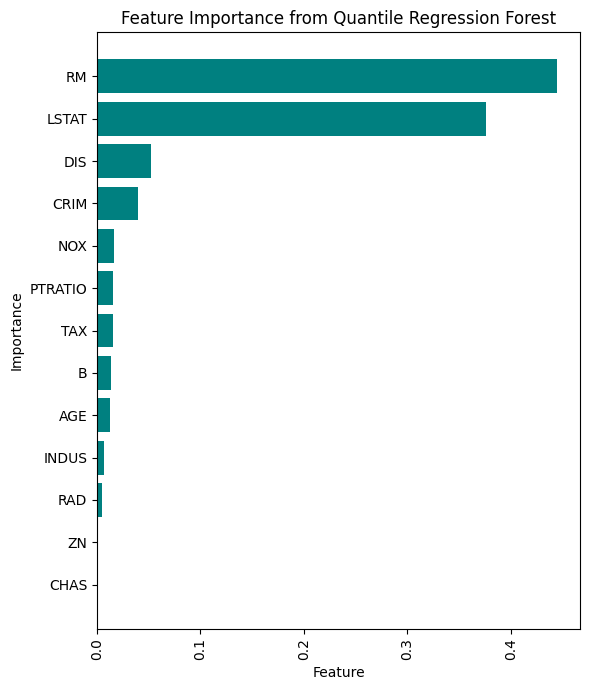

In [14]:
# Variable Importance
feature_importance = qrf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

print("\nFeature Importance:")
print(importance_df)

# Visualize Feature Importance
plt.figure(figsize=(6, 7))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Quantile Regression Forest')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

 Hyperparameter tuning involves selecting optimal values for parameters like `n_estimators`, `max_depth`, and `min_samples_split` to improve model performance. We’ll use Grid Search with cross-validation to identify the best parameters, focusing on the Boston Housing dataset and the quantile-forest package. Performance will be evaluated using Mean Absolute Error (MAE) for the median predictions and Quantile Loss for the 0.1 and 0.9 quantiles, as before.

1. Define Hyperparameter Grid: Specify ranges for key QRF parameters.
2. Grid Search with Cross-Validation: Use GridSearchCV to evaluate combinations of parameters, optimizing for MAE on the median quantile.
3. Fit Model with Best Parameters: Retrain the QRF model using the optimal parameters.
4. Evaluate Model: Compute MAE and Quantile Loss on the test set, and assess variable importance.

Below is the Python code, building on your provided data preparation code.

Hyperparameter Grid:

- `n_estimators`: Number of trees ([50, 100, 200]).
- `max_depth`: Maximum tree depth ([None, 10, 20]).
- `min_samples_split`: Minimum samples to split a node ([2, 5, 10]).
- `min_samples_leaf`: Minimum samples at a leaf ([1, 2, 4]).

These parameters control model complexity and overfitting.

In [15]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [16]:
# Initialize Quantile Regression Forest
qrf = RandomForestQuantileRegressor(random_state=seeds)

In [ ]:
# Custom scoring function for median (0.5 quantile) MAE
def median_mae_scorer(estimator, X, y):
    y_pred = estimator.predict(X, quantiles=[0.5])[:, 0]
    return -mean_absolute_error(y, y_pred)  # Negative because GridSearchCV maximizes

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=qrf,
    param_grid=param_grid,
    scoring=median_mae_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
# Fit Grid Search
grid_search.fit(train_X, train_y)

In [18]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation MAE (median):", -grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation MAE (median): nan


In [19]:
# Fit QRF with best parameters
best_qrf = RandomForestQuantileRegressor(**grid_search.best_params_, random_state=seeds)
best_qrf.fit(train_X, train_y)

RandomForestQuantileRegressor(n_estimators=50, random_state=11076)

In [20]:
# Predict quantiles on test set
quantiles = [0.1, 0.5, 0.9]
y_pred_quantiles = best_qrf.predict(test_X, quantiles=quantiles)

# Extract predictions for each quantile
y_pred_lower = y_pred_quantiles[:, 0]  # 0.1 quantile
y_pred_median = y_pred_quantiles[:, 1]  # 0.5 quantile (median)
y_pred_upper = y_pred_quantiles[:, 2]  # 0.9 quantile

# Evaluate model performance
# Mean Absolute Error for median predictions
mae_median = mean_absolute_error(test_y, y_pred_median)
print(f"\nTest MAE for median predictions: {mae_median:.2f}")

# Quantile Loss for 0.1 and 0.9 quantiles
def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.mean(np.where(errors >= 0, quantile * errors, (quantile - 1) * errors))

qloss_lower = quantile_loss(test_y, y_pred_lower, 0.1)
qloss_upper = quantile_loss(test_y, y_pred_upper, 0.9)
print(f"Test Quantile Loss (0.1): {qloss_lower:.2f}")
print(f"Test Quantile Loss (0.9): {qloss_upper:.2f}")


Test MAE for median predictions: 2.33
Test Quantile Loss (0.1): 0.49
Test Quantile Loss (0.9): 0.56



Feature Importance:
    Feature  Importance
3      CHAS    0.000582
1        ZN    0.000770
8       RAD    0.004766
2     INDUS    0.007126
6       AGE    0.010056
11        B    0.014141
9       TAX    0.015822
4       NOX    0.016022
10  PTRATIO    0.017775
0      CRIM    0.040783
7       DIS    0.059501
12    LSTAT    0.398008
5        RM    0.414649


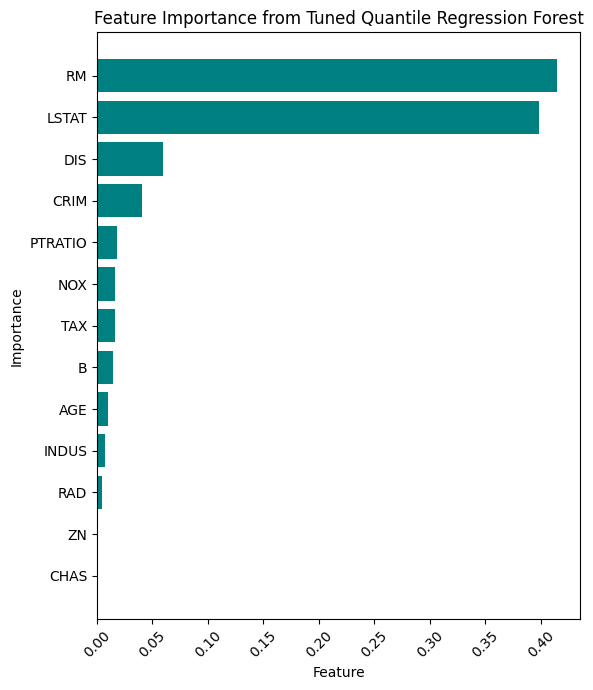

In [21]:
# Variable Importance
feature_importance = best_qrf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

print("\nFeature Importance:")
print(importance_df)

# Visualize Feature Importance
plt.figure(figsize=(6, 7))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Tuned Quantile Regression Forest')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary and Conclusions

Quantile Regression Forest extends Random Forests to estimate conditional quantiles, providing a robust, non-parametric way to model the full distribution of a response variable. It works by collecting observations from tree leaves and computing quantiles from the empirical distribution. It’s particularly valuable for applications requiring uncertainty quantification or modeling non-standard distributions. This tutorial  demonstrated how to implement QRF from scratch, fit a model using the {quantregForest} package, and perform hyperparameter tuning with k-fold cross-validation. The results showed how to predict quantiles and evaluate model performance using quantile loss.

## References

1.  Meinshausen, N. (2006). Quantile Regression Forests. Journal of Machine Learning Research, 7, 983–999.

2.  Athey, S., Tibshirani, J., & Wager, S. (2019). Generalized Random Forests. The Annals of Statistics, 47(2), 1148–1178

3.  Koenker, R., & Bassett, G. (1978). Regression Quantiles. Econometrica, 46(1), 33–50.

4.  Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32.

5.  Zhang, H., Zimmerman, J., Nettleton, D., & Nordman, D. J. (2019). Random Forest Prediction Intervals. The American Statistician, 74(4), 392–406.

6. [Medium: Quantile Regression Tutorial by Chris Kuo](https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-3a1588862e99)